In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


#from tensorflow.keras.models import Model
#from tensorflow.keras.models import load_model
from tensorflow.keras import layers, activations
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
#from tensorflow.keras.layers import TextVectorization
#from tensorflow.keras.optimizers import *


import sklearn as sk
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import itertools
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import Data

In [2]:
df = pd.read_csv("../labeled_data.csv")

In [3]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


# Tokenizer

Tokenize all words contained in the Tweets of the Dataset.

The Tweets are stored in the dataframe df (column "tweet")

In [4]:
#Split String for each word
def toLowerAndSplit(tweet):
    tweet = tweet.lower()
    tweet = tweet.split()
    return tweet

In [5]:
tweets = pd.DataFrame(df["tweet"].apply(toLowerAndSplit))

In [6]:
tweets

,tweet
0,"[!!!, rt, @mayasolovely:, as, a, woman, you, s..."
1,"[!!!!!, rt, @mleew17:, boy, dats, cold...tyga,..."
2,"[!!!!!!!, rt, @urkindofbrand, dawg!!!!, rt, @8..."
3,"[!!!!!!!!!, rt, @c_g_anderson:, @viva_based, s..."
4,"[!!!!!!!!!!!!!, rt, @shenikaroberts:, the, shi..."
...,...
24778,"[you's, a, muthaf***in, lie, &#8220;@lifeaskin..."
24779,"[you've, gone, and, broke, the, wrong, heart, ..."
24780,"[young, buck, wanna, eat!!.., dat, nigguh, lik..."
24781,"[youu, got, wild, bitches, tellin, you, lies]"


In [7]:
#Create a list containing all words mentioned in tweets
all_words = list(itertools.chain(*tweets["tweet"]))

## Count Words

In [8]:
# Count of every word
word_counts = Counter(all_words)

df_uncleaned = pd.DataFrame(word_counts.most_common(10))


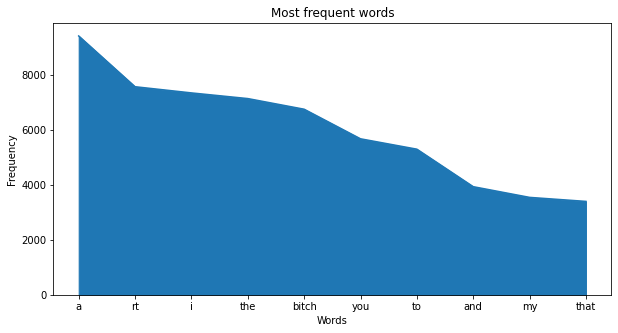

In [9]:
df_uncleaned.plot(kind = "area",
             title = "Most frequent words", 
             legend = False,
             xlabel = "Words",
             ylabel = "Frequency",
             figsize = (10, 5))
plt.xticks(range(0,len(df_uncleaned.index)), df_uncleaned[0])
plt.show()

## Remove stopwords

To gain more substantial insight into the data, stopwords such as "i", "a", "at", "the" have to be removed. These words construct the grammatical dependencies of the english language, but do not contain any relevant information to determine hate speech.

## Remove Tags

Twitter tags such as @genericUser do not give further insight for hate speech detection purposes. Thus, they have to be removed.

## Remove Links

Similar to stopwords and Tags, links do not add meaningfull information to the purpose of hate speech --> remove

## Remove Twitter Elements

The Tweets can contain Twitter excluvsive information, such as "rt", "rts" or "retweet". These formulations do not add any meaning to the Tweets content and have therefore to be removed.

In [10]:
#Uncomment if nltk stopwords were not downloaded yet
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jonas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
#Define variable wit henglish stopwords
sw = stopwords.words("english")
twitter_elements = ["rt", "rts", "retweet"]
i_elements = ["i", "i'm", "im", "iam"] # remove u?
most_common = word_counts.most_common()



def removeNoiseWordCount(word_list):
    cleaned_word_list = []
    for element in word_list:
        #Removes words contained in stopwords
        if element[0] not in sw:
            #Removes words with @ --> remove Tags
            if "@" not in element[0]: 
                #Removes words containing http --> links
                if "http" not in element[0]:
                    hasTwitterElement = False
                    hasIElement = False
                    for tw in twitter_elements:
                        if tw in element:
                            hasTwitterElement = True
                    for ie in i_elements:
                        if ie in element:
                            hasIElement = True
                    if hasTwitterElement == False and hasIElement == False:
                        cleaned_word_list.append(element)

    return cleaned_word_list

In [12]:
cleaned_word_list_complete = removeNoiseWordCount(most_common)

In [13]:
df_cleaned_top10 = pd.DataFrame(cleaned_word_list_complete[:10])

In [14]:
df_cleaned_top10

,0,1
0,bitch,6749
1,bitches,2677
2,like,2674
3,hoes,1977
4,pussy,1731
5,hoe,1483
6,ass,1472
7,get,1413
8,fuck,1311
9,got,1275


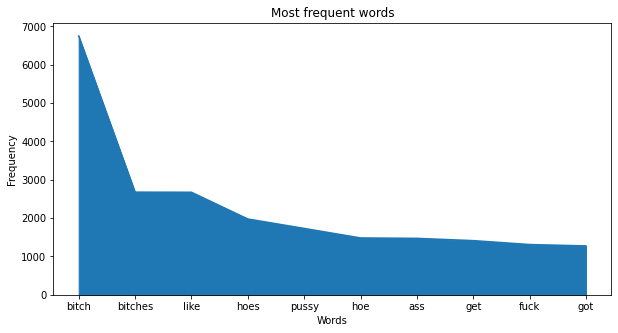

In [15]:
df_cleaned_top10.plot(kind = "area",
             title = "Most frequent words", 
             legend = False,
             xlabel = "Words",
             ylabel = "Frequency",
             figsize = (10, 5))
plt.xticks(range(0,len(df_cleaned_top10.index)), df_cleaned_top10[0])
plt.show()

In [16]:
def removeNoiseFromTweet(word_list):
    cleaned_word_list = []
    for element in word_list:
        for word in element:
            #Removes words contained in stopwords
            if word not in sw:
                #Removes words with @ --> remove Tags
                if "@" not in word: 
                    #Removes words containing http --> links
                    if "http" not in word:
                        hasTwitterElement = False
                        hasIElement = False
                        #Removes Twitter exclusive Words (retweet/ rt...) 
                        for tw in twitter_elements:
                            if tw in word:
                                hasTwitterElement = True
                        for ie in i_elements:
                            if ie in element:
                                hasIElement = True
                        if hasTwitterElement == False and hasIElement == False:
                            #Remove special characters from string
                            cleaned_word = ""
                            cleaned_word = "".join(character for character in word if character.isalnum())
                            if cleaned_word != "":
                                cleaned_word_list.append(cleaned_word)
        return cleaned_word_list

In [17]:
#Apply the removeNoiseFromTweet function with axis = 1 --> compute for every row
cleaned_words_df = tweets.apply(func=removeNoiseFromTweet, axis=1)

In [18]:
#Cleaned pandas series element 
cleaned_words_df

0        [woman, complain, cleaning, house, amp, man, a...
1        [boy, dats, coldtyga, dwn, bad, cuffin, dat, h...
2           [dawg, ever, fuck, bitch, cry, confused, shit]
3                                     [look, like, tranny]
4        [shit, hear, might, true, might, faker, bitch,...
                               ...                        
24778    [yous, muthafin, lie, right, tl, trash, 8230, ...
24779    [gone, broke, wrong, baby, drove, redneck, crazy]
24780                                                   []
24781             [youu, got, wild, bitches, tellin, lies]
24782    [ruffled, ntac, eileen, dahlia, beautiful, col...
Length: 24783, dtype: object

# Word Stems

To further ensure high data quality, we should remove plural words from the pool (e.g. in plot above: bitch/ bitches currently are seperate entities at this point). 

In [19]:
#Remove Comment when running the first time
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jonas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
stemmer = PorterStemmer()
def stemWords(tweet):
    word_stems = []
    for word in tweet:
        
        word_stems.append(stemmer.stem(word))
        
    return word_stems

In [21]:
word_stems = cleaned_words_df.apply(stemWords)

In [22]:
word_stems

0        [woman, complain, clean, hous, amp, man, alway...
1        [boy, dat, coldtyga, dwn, bad, cuffin, dat, ho...
2             [dawg, ever, fuck, bitch, cri, confus, shit]
3                                     [look, like, tranni]
4        [shit, hear, might, true, might, faker, bitch,...
                               ...                        
24778    [you, muthafin, lie, right, tl, trash, 8230, n...
24779    [gone, broke, wrong, babi, drove, redneck, crazi]
24780                                                   []
24781                [youu, got, wild, bitch, tellin, lie]
24782    [ruffl, ntac, eileen, dahlia, beauti, color, c...
Length: 24783, dtype: object

In [23]:
#Create a list containing all words mentioned in tweets
stem_words = list(itertools.chain(*word_stems))

In [24]:
# Count of every word
word_counts_stem = Counter(stem_words)

df_stem = pd.DataFrame(word_counts_stem.most_common(10))


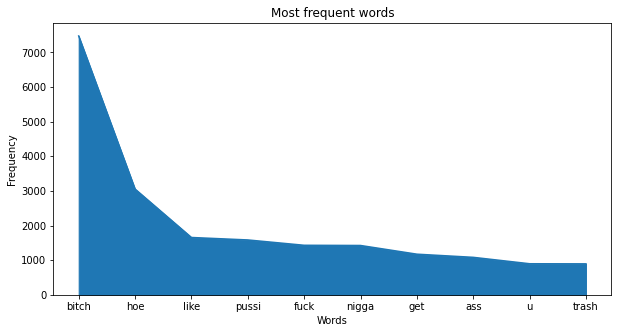

In [25]:
df_stem.plot(kind = "area",
             title = "Most frequent words", 
             legend = False,
             xlabel = "Words",
             ylabel = "Frequency",
             figsize = (10, 5))
plt.xticks(range(0,len(df_stem.index)), df_stem[0])
plt.show()

## Word Count for Hate speech

In [26]:
# hier könnten wir noch nen vergleich der länge zwischen hate speech und anderen tweets herstellen

## Model Training

In [27]:
#change elements of column from list to string
def makeString(column):
    result = " ".join(column)
    return result

In [28]:
word_stems_text = word_stems.apply(makeString)

In [29]:
#split into train and test set
X_train, X_test, y_train, y_test = train_test_split(word_stems_text, df["class"], test_size=0.2, shuffle=True, random_state=10)

In [30]:
#x_train_tok = [nltk.word_tokenize(i) for i in X_train]
#x_test_tok = [nltk.word_tokenize(i) for i in X_test]

In [31]:
X_train

700           dutch peopl live outsid newyorkc white trash
3015                          bitch like it mean someth me
9011                                                      
10395                                                     
8422     charli crist outlaw hate redicul vilifi shake ...
                               ...                        
9372                               gabbi bitch two account
7291                                        dark ie nig ok
17728                  cant believ bitch find remot appeal
7293     perfect stock photographi let leprechaunlook h...
17673                                                     
Length: 19826, dtype: object

In [32]:
#Benötigt von Logistic Regression
tfid = TfidfVectorizer(lowercase=False)
x_train_vec = tfid.fit_transform(X_train)
x_test_vec = tfid.transform(X_test)

In [33]:
x_train_vec

<19826x14633 sparse matrix of type '<class 'numpy.float64'>'
	with 98477 stored elements in Compressed Sparse Row format>

In [34]:
#When C < 1 --> better results
lr = LogisticRegression(solver="liblinear", penalty="l2", C=1)

In [35]:
lr.fit(x_train_vec, y_train)

LogisticRegression(C=1, solver='liblinear')

In [36]:
y_predict = lr.predict(x_test_vec)

In [37]:
y_prob = lr.predict_proba(x_test_vec)[:,1]

In [38]:
print(classification_report(y_test, y_predict))
print(confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.68      0.10      0.17       285
           1       0.85      0.99      0.91      3815
           2       0.88      0.48      0.62       857

    accuracy                           0.85      4957
   macro avg       0.80      0.52      0.57      4957
weighted avg       0.84      0.85      0.82      4957

[[  28  239   18]
 [  12 3764   39]
 [   1  441  415]]


# Naive Bayes

In [39]:
tfid = TfidfVectorizer(lowercase=False)
x_train_vec_nn = tfid.fit_transform(X_train)
#x_test_vec = tfid.transform(X_test)

In [40]:
x_train_vec_nn

<19826x14633 sparse matrix of type '<class 'numpy.float64'>'
	with 98477 stored elements in Compressed Sparse Row format>

In [41]:
nb_tfidf = MultinomialNB(alpha=0, fit_prior=True)
nb_tfidf.fit(x_train_vec_nn, y_train)  

D:\Tools\Anaconda\envs\test\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


MultinomialNB(alpha=0)

In [42]:
y_predict = nb_tfidf.predict(x_test_vec)

In [43]:
print(classification_report(y_test,y_predict))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.33      0.05      0.09       285
           1       0.82      0.96      0.89      3815
           2       0.66      0.35      0.46       857

    accuracy                           0.80      4957
   macro avg       0.61      0.45      0.48      4957
weighted avg       0.77      0.80      0.77      4957

Confusion Matrix:
[[  15  246   24]
 [  22 3665  128]
 [   8  550  299]]


# Data for Neural Networks

In [44]:
train_tweet = X_train
test_tweet = X_test

tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(train_tweet)
train_tweet = tokenizer.texts_to_sequences(train_tweet)
test_tweet = tokenizer.texts_to_sequences(test_tweet)

train_tweet = pad_sequences(train_tweet, maxlen=27)
test_tweet = pad_sequences(test_tweet, maxlen=27)

In [45]:
encoder = LabelEncoder()

y_train_categorical = encoder.fit_transform(y_train)
y_train_categorical = to_categorical(y_train) 

y_test_categorical = encoder.fit_transform(y_test)
y_test_categorical = to_categorical(y_test) 

In [46]:
epoch = 100
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Dense Neural Network

In [47]:
y_train

700      0
3015     1
9011     0
10395    1
8422     2
        ..
9372     0
7291     1
17728    1
7293     2
17673    1
Name: class, Length: 19826, dtype: int64

In [ ]:
def model_1():
    model = Sequential()
    model.add(keras.layers.Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = 27))
    #model.add(keras.layers.LSTM(128))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

train_model_1 = model_1()

history_model_1 = train_model_1.fit(
           train_tweet,
           y_train_categorical,
           validation_data=(test_tweet,y_test_categorical),
           epochs= epoch,
           callbacks=[earlyStop])

Epoch 1/100
620/620 [==============================] - 10s 16ms/step - loss: 0.5035 - accuracy: 0.8274 - val_loss: 0.4326 - val_accuracy: 0.8604
Epoch 2/100
105/620 [====>.........................] - ETA: 7s - loss: 0.3824 - accuracy: 0.8783

In [ ]:
predictions = train_model_1.predict(test_tweet)

In [ ]:
predictions

def checkPrediction(pred):
    cleaned_prediction = []
    print(pred)
    biggest_number = 0
    to_insert = 0
    for element in pred:
        for count in range(len(element)):
            if element[count] > biggest_number:
                biggest_number = element[count]
                to_insert = count
        biggest_number = 0
        cleaned_prediction.append(to_insert)
        to_insert = 0
    return cleaned_prediction

pred_cleaned = checkPrediction(predictions)
y_test_cleaned = checkPrediction(y_test_categorical)

In [ ]:
print(classification_report(y_test_cleaned, pred_cleaned))
print('Confusion Matrix:')
print(confusion_matrix(y_test_cleaned, pred_cleaned))

In [ ]:
plt.plot(history_model_1.history["loss"])

# Custom Weights

In [ ]:
custom_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
print(custom_weights)

In [ ]:
def custom_weights_to_dictionary(weights):
    dic = {}
    for i in range(len(weights)):
        dic[i] = weights[i]
    return dic

weights = custom_weights_to_dictionary(custom_weights)
print(weights)

In [ ]:
def model_2():
    model = Sequential()
    model.add(keras.layers.Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = 27))
    #model.add(keras.layers.LSTM(128, input_shape=((128,7),)))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

train_model_2 = model_2()
#train_tweet_pd = pd.DataFrame(train_tweet)
history_model_2 = train_model_2.fit(
                   train_tweet,
                   y_train_categorical,
                   validation_data=(test_tweet,y_test_categorical),
                   class_weight=weights,
                   epochs= epoch,
                   callbacks=[earlyStop])

In [ ]:
predictions = train_model_2.predict(test_tweet)

pred_cleaned = checkPrediction(predictions)

print(classification_report(y_test_cleaned, pred_cleaned))
print('Confusion Matrix:')
print(confusion_matrix(y_test_cleaned, pred_cleaned))

In [ ]:
plt.plot(history_model_2.history["loss"])

# CNN

In [ ]:
def model_3():
    model = Sequential()
    model.add(keras.layers.Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = 27))
    #model.add(keras.layers.LSTM(128, input_shape=((128,7),)))
    model.add(keras.layers.Conv1D(128, 5, activation='relu'))
    #model.add(keras.layers.MaxPooling1D(pool_size=1))
    model.add(keras.layers.Conv1D(128, 5, activation='relu'))
    #model.add(keras.layers.MaxPooling1D(pool_size=1))
    model.add(keras.layers.Conv1D(128, 5, activation='relu'))
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

train_model_3 = model_3()
#train_tweet_pd = pd.DataFrame(train_tweet)
history_model_3 = train_model_3.fit(
                   train_tweet,
                   y_train_categorical,
                   validation_data=(test_tweet, y_test_categorical),
                   class_weight=weights,
                   epochs=epoch,
                   callbacks=[earlyStop])

In [ ]:
predictions = train_model_3.predict(test_tweet)

pred_cleaned = checkPrediction(predictions)

print(classification_report(y_test_cleaned, pred_cleaned))
print('Confusion Matrix:')
print(confusion_matrix(y_test_cleaned, pred_cleaned))

# Rumprobieren

In [ ]:
asd

In [ ]:
#split into train and test set
tokenizer = Tokenizer()
tokenizer.fit_on_texts(word_stems_text)

word_stems_text = tokenizer.texts_to_sequences(word_stems_text)

word_stems_text = pd.DataFrame(word_stems_text)

X_train, X_test, y_train, y_test = train_test_split(word_stems_text, df["class"], test_size=0.2, shuffle=True, random_state=10)

In [ ]:
vectorize_layer = TextVectorization(
 max_tokens=None,
 output_mode='int',
 output_sequence_length=100)

In [ ]:
#tokenizer = Tokenizer()
#tokenizer.fit_on_texts(X_train)

#X_train = tokenizer.texts_to_sequences(X_train)

In [ ]:
test = pd.DataFrame(X_train)
#test.dropna(subset = [0], inplace=True)

In [ ]:
inputs = tf.keras.Input(shape=(27,))# dtype=tf.string, name='text')

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
#x = vectorize_layer(inputs)
#x = layers.Embedding(1, 1)(x)
#x = layers.Conv2D(filters=32, kernel_size=(5, 5))(x)

#x = layers.Dropout(0.5)(x)

x = layers.Dense(128)(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128)(x)
x = layers.Dense(128)(x)



# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="Huber", optimizer="adam", metrics=["accuracy"])

In [ ]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(len(df_stem.index), 1024, input_length=27))
model2.add(keras.layers.Conv1D(128, 5, activation='relu'))
#model2.add(keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
#model2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model2.add(keras.layers.GlobalAveragePooling1D())
model2.add(keras.layers.Dropout(0.5))
model2.add(keras.layers.Dense(16, activation = "relu"))
model2.add(keras.layers.Dense(16, activation = "relu"))
model2.add(keras.layers.Dense(16, activation = "relu"))
model2.add(keras.layers.Dense(16, activation = "relu"))

model2.add(keras.layers.Dense(1, activation = "sigmoid"))


model2.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"])

In [ ]:
X_train = X_train.fillna(0)
X_train = X_train.astype(int)

In [ ]:
count = X_train.index[X_train[0] == 0].tolist()

X_train = X_train.drop(count)
y_train = y_train.drop(count)

In [ ]:
X_train

In [ ]:
model2.fit(X_train,
          y_train, 
          epochs=10)

In [ ]:
#tokenizer = Tokenizer()
#tokenizer.fit_on_texts(X_test)

#X_test = tokenizer.texts_to_sequences(X_test)

#X_test = pd.DataFrame(X_test)
#X_test = X_test.fillna(0)

In [ ]:
X_test = X_test.fillna(0)
X_test = X_test.astype(int)
predictions = model.predict(X_test)

In [ ]:
predictions

In [ ]:
X_train

In [ ]:
pred_list = []
for item in predictions:
    pred_list.append(int(item))

In [ ]:
print(classification_report(y_test, pred_list))
print(confusion_matrix(y_test, pred_list))

In [ ]:
for element in pred_list:
    print(element)
    #if element[0] != "nan":
        #print("yee")

In [ ]:
for element in predictions:
    print(element)

In [ ]:
y_train